# Dimensionality Reduction

In [ ]:
from sklearn.datasets import load_digits as load_data
import pandas as pd

data = load_data()
data.keys()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']


- Reduce the number of features to turn an intractable problem → Tractable one
    - e.g. drop the while pixels from MNIST dataset without losing information
- But
    - May cause info loss ⇒ Slightly worse performance
    - More complex pipelines (may actually increase training time, so consider fitting original data if training is too slow)
    - May also filter out some noise and unnecessary details, but not in general
- Also
    - Helps in DataViz (to communicate conclusions with non-data scientists)

## The Curse of Dimensionality

- High dimensional datasets are at the risk of being very sparse (Very very low density). Distance between two random points on average in a:
    - 2D  unit square:  0.52
    - 3D unit cube: 0.66
    - 1000000-dimensional hypercube: 408.25 (Yes! In a unit hypercube)
- This means that new instances will likely be **very far away** from training instances in a high dimensional setting
- In theory, one solution: increase the size of the training set to reach sufficient density. Reality: the required number grows exponentially with the number of dimensions

## Main Approaches for Dimensionality Reduction

1. **Projection**: Project it onto a lower dimensional plane (where instances are closer to each other)
 - But doens't always work because "Swiss Roll toy dataset" exists (there has to be a better way)
2.**Manifold**: A shape that can be bent and twisted in a higher-dimensional space. (Like the Swiss roll toy dataset)
 - $d$-dim mannifold $\in$ $n$-dim space ($d\lt n$)
 - *manifold assumption/hypothesis*: empirically observed, a lower-dim manifold exists
 - another implicit assumption: the task at hand can be made simpler if expressed as such.
 - Results/effectiveness *depend* on the dataset!

## PCA

- Identify the hyperplane closest to data and project  the data onto it

- Project onto the hyperplane with the minimum reduction in variance, to ensure that there is minimal loss of information

- First Principle component: axis that accounts for the largest amount of variance
- Second axis => Orthogonal to the first one (largest amount of *remaining* variance)
- The direction of the unit vectors returned by PCA is not stable (can fluctuate between -1 and 1) but the unit vector will definitely lie on the same axis.
    - Pair of unit vectors may even rotate or swap (if variance along these two axes are close)
- To find the principle components, use SVD $X = U\Sigma V^T$
    - $V$ contains the unit vectors that define all the principal components




In [ ]:
import numpy as np

# center X  in all dimensions
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0] # 1st PC
c2 = Vt.T[:, 1] # 2nd PC

- Sklearn takes care of centering (PCA assumes data is centered)
- project the data onto the hyperplane defined by the first $d$ principal components => reduced dataset $X_{\text{d-proj}}$
- $X_{\text{d-proj}} = XW_d$ (where $W_d$ is defined as the matrix containing the  first $d$ columns of $V$)


In [ ]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D

0          1
0      1.259466 -21.274883
1     -7.957611  20.768699
2     -6.991923   9.955986
3     15.906105  -3.332464
4    -23.306867  -4.269061
...         ...        ...
1792  14.606628 -13.344124
1793  -6.464574 -20.567299
1794 -10.801284   6.960252
1795   4.872100 -12.423954
1796   0.344390  -6.365549

[1797 rows x 2 columns]

- This is how we reduce the dimensionality. We can also do the same using `sklearn`

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # set the number of components in the PCA
X2D = pca.fit_transform(X)
X2D

array([[ -1.25946641,  21.27488155],
       [  7.95761175, -20.76869944],
       [  6.99192262,  -9.95598445],
       ...,
       [ 10.80128403,  -6.96025899],
       [ -4.87210113,  12.42396801],
       [ -0.34438981,   6.36554627]])

- `pca.components_` = $W_d^T$
- `pca.components_.T[:, 0]` is the first principal component

In [ ]:
# PROOF that its a unit vector:
sum(pca.components_.T[:, 0]**2)

1.0000000000000004

- *explained variance ratio* = proportion of the dataset's variance that lies along each PC

In [ ]:
pca.explained_variance_ratio_

array([0.14890594, 0.13618771])

In this case the PCs don't explain much of the variance of the original dataset, so it may not be useful to use PCA here. In the book however, the first PC explained $84.2\%$ of the variance of the dataset. Hence, it would be worth using those components without losing much information.

- Choose the number of dimensionns that add up to a sufficiently large portion of the variance.

In [ ]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

29


In [ ]:
cumsum >= 0.95

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

But instead of diong this. We can directly specify a float between 0 and 1 in the `n_components` to specify this exact thing and directly train the pca

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(X)
pca.n_components_

29

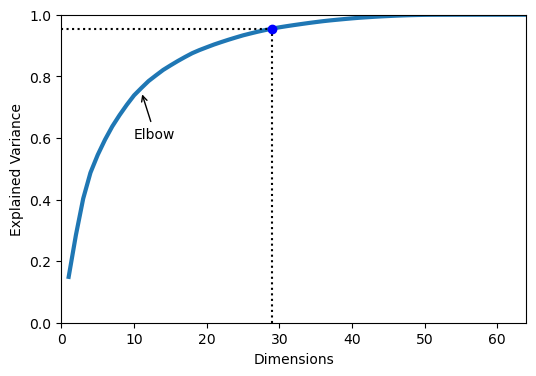

In [ ]:
# @markdown Yet another option is to plot the explained variance as a function of the number of dimensions
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.axis([0,64,0,1])
d = pca.n_components_
explained = np.sum(pca.explained_variance_ratio_)
plt.plot(range(1,65),cumsum,linewidth=3 )
plt.plot([d,d],[0,explained], 'k:')
plt.plot([0,d],[explained,explained], 'k:')
plt.annotate("Elbow", xy=(11,0.75), xytext=(10,0.6), arrowprops=dict(arrowstyle="->"))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.plot(d, explained, 'bo')
plt.show()

- Compression: 95% of the variance preserved in less than 20% of the size of the data! That's crazy! Will speed up the classification algorithm
- Decompress: apply the inverse transformation of the PCA projection
$$
X_{\text{recovered}} = X_{\text{d-proj}}W_d^T
$$

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_centered)
# Decompress: recover
X_recovered = pca.inverse_transform(X_reduced)

- Randomized SVD approach $O(m \times d^2) + O(d^3)$ instead of Full SVD appraoch $O(m\times n^2) + O(n^2)$
- set the `svd_solver="randomized"`. Dramatically faster (default="auto", $n$ or $m > 500$ ⇒ *Randomized* else *Full* SVD (alternatively set `svd_solver="full"`)

In [ ]:
rnd_pca = PCA(n_components=d, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X)

- PCA problem: Whole training set should fit in memory
- Solution: IPCA (*Incremental* PCA)
    - Useful for large training sets
    - Online PCA (on the fly)
- `partial_fit` for each mini-batch

In [ ]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=17)
for X_batch in np.array_split(X, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X)

- Or use `np.memmap` which allows manipulation of a large array stored in **binary files** as if the array was entirely in memory (loads the data in memory, when needed)

In [ ]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

## Kernel PCA

- Kernet trick: implicitly map instances into very high-dimensional space (*feature space*) to allow for nonlinear classification. (recall: a line with three disjoint subsets of instances, the instances could be separated by taking $y=x^2$ and then drawingg a parabola as an SVM)
- We can preserve clusters of instances after projection and also unroll datasets that lie closed to a twisted manifold by using **kPCA (Kernel PCA)**

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components= 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

- There is no obvious performance measure to help select the best kernel
- Dim Reduction is a prep step for supervised learning tasks... so we can use grid search to select the kernel and hyperparameters that lead to the best performance in this task
- 2 step pipeline
    - reduce dimensionality
    - apply logistic regression for classification

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [ ]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}


- Another (entirely unsupervised) technique to select the kernel and hyperparamters (gamma) is to compare the reconstruction error. Reflecting the information loss by the procedure

- Didn't quite understand reconstructionn error. #later

In [ ]:
# rbf_pca = KernelPCA(n_components= 2, kernel="rbf", gamma="0.03", fit_inverse_transform=True)

# X_reduced = rbf_pca.fit_transform(X)
# X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

## LLE

- Locally Linear Embedding: another *nonlinear dimensionality reduction* (NLDR) technique.
- Manifold learning technique (doesn't rely on projections)
- Measures "How each training instances linearly relates to its closest neighbour (c.n.) and then look for a low-dimensional representation of the training set"


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

- Swiss roll is unrolled and the distances between instances are **locally well preserved**
- But not preserved on a larger scale (e.g. left part stretched, right part squeezed)
- The idea is simple
 - Try to express $x^{(i)}$ as a linear function of its k-c.n., $\sum_{j=1}^m w_{i,j}x^{(j)}$ (where $w_{i,j}=0$ if not k-nearest neighbor). Do a coinstrained optimization and find the weights $\hat{W}$
 - Now try to reconstruct all the training instances on the lower dimensional space using the weights obtained, $\hat{W}$ (keeping the weights constant, but allowing the position of the training instances to change in the d-dimensional space $d < n$)


## Other Dimensionality Reduction

- Random Projections: Projects data to a lower-dim space using a random linear projection. Crazy!
- Multidimensional Scaling (MDS): Reduce dim while trying to preserve distances between the instances
- Isomap: Create a graph by connecting c.n. then reduce dimensionality while preserving geodesic distances (number of nodes in the shortest path between two nodes) between the instances
<!-- - t-Distributed Stochastic Neighbor Embedding (t-SNE):  reduce dimensionality while keeping similar instances close and dissimilar instances apart -->
<!-- - Linear Discriminant Analysis (LDA):  -->